In [ ]:
from __future__ import absolute_import
import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import Layer
from keras.engine import InputSpec
from keras.legacy import interfaces
from keras.layers import RNN
# from keras.layers.recurrent import _generate_dropout_mask, _generate_dropout_ones

class IndRNNCell(Layer):
    """Independently Recurrent Neural Networks Cell class.

    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)

    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        recurrent_clip_max: Can be one of None or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix, used for the linear transformation of the
            recurrent state.
            Can be `None` or an available initializer. Defaults to `None`.
            If None, defaults to uniform initialization.
            If None, and recurrent_clip_min/max is not None, then
            it uses those clip values as for uniform initialization.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, must be 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 recurrent_clip_min=-1,
                 recurrent_clip_max=-1,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(IndRNNCell, self).__init__(**kwargs)

        if implementation != 2:
            warnings.warn(
                "IndRNN only supports implementation 2 for the moment. Defaulting to implementation = 2")
            implementation = 2

        if recurrent_clip_min is None or recurrent_clip_max is None:
            recurrent_clip_min = None
            recurrent_clip_max = None

        self.units = units
        self.recurrent_clip_min = recurrent_clip_min
        self.recurrent_clip_max = recurrent_clip_max
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer) \
                                     if recurrent_initializer is not None else None
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = (self.units,)
        self._dropout_mask = None
        self._recurrent_masks = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if self.recurrent_clip_min == -1 or self.recurrent_clip_max == -1:
            self.recurrent_clip_min = 0.0

            if hasattr(self, 'timesteps') and self.timesteps is not None:
                self.recurrent_clip_max = pow(2.0, 1. / self.timesteps)
            else:
                warnings.warn("IndRNNCell: Number of timesteps could not be determined. \n"
                              "Defaulting to max clipping range of 1.0. \n"
                              "If this model was trained using a specific timestep during training, "
                              "inference may be wrong due to this default setting.\n"
                              "Please ensure that you use the same number of timesteps during training "
                              "and evaluation")
                self.recurrent_clip_max = 1.0

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      name='input_kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.recurrent_initializer is None:
            if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
                initialization_value = min(self.recurrent_clip_max, 1.0)
                self.recurrent_initializer = initializers.uniform(-initialization_value,
                                                                  initialization_value)
            else:
                self.recurrent_initializer = initializers.uniform(-1.0, 1.0)

        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                                name='recurrent_kernel',
                                                initializer=self.recurrent_initializer,
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)

        if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
            if abs(self.recurrent_clip_min):
                abs_recurrent_kernel = K.abs(self.recurrent_kernel)
                min_recurrent_kernel = K.maximum(abs_recurrent_kernel, abs(self.recurrent_clip_min))
                self.recurrent_kernel = K.sign(self.recurrent_kernel) * min_recurrent_kernel

            self.recurrent_kernel = K.clip(self.recurrent_kernel,
                                           self.recurrent_clip_min,
                                           self.recurrent_clip_max)

        if self.use_bias:
            bias_initializer = self.bias_initializer

            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                _generate_dropout_ones(inputs, K.shape(inputs)[-1]),
                self.dropout,
                training=training,
                count=1)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_masks is None):
            _recurrent_mask = _generate_dropout_mask(
                _generate_dropout_ones(inputs, self.units),
                self.recurrent_dropout,
                training=training,
                count=1)
            self._recurrent_masks = _recurrent_mask

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_masks = self._recurrent_masks

        h_tm1 = states[0]  # previous state

        if 0. < self.dropout < 1.:
            inputs *= dp_mask[0]

        if 0. < self.recurrent_dropout < 1.:
            h_tm1 *= rec_dp_masks[0]

        h = K.dot(inputs, self.kernel)
        h = h + (h_tm1 * self.recurrent_kernel)

        if self.use_bias:
            h = K.bias_add(h, self.bias)

        h = self.activation(h)

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class IndRNN(RNN):
    """Independently Recurrent Neural Networks Cell class.

    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)

    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        recurrent_clip_max: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.](http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output.
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.

    # References
        - [Learning to forget: Continual prediction with NestedLSTM](http://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015)
        - [Supervised sequence labeling with recurrent neural networks](http://www.cs.toronto.edu/~graves/preprint.pdf)
        - [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](http://arxiv.org/abs/1512.05287)
        - [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 recurrent_clip_min=-1,
                 recurrent_clip_max=-1,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=2`.'
                          'Please update your layer call.')
        if K.backend() == 'theano':
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = IndRNNCell(units,
                          recurrent_clip_min=recurrent_clip_min,
                          recurrent_clip_max=recurrent_clip_max,
                          activation=activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          implementation=implementation)
        super(IndRNN, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     return_state=return_state,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     unroll=unroll,
                                     **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def build(self, input_shape):
        timesteps = input_shape[1]

        if timesteps is None:
            warnings.warn("Number of timesteps was not provided. If this model is being used for training purposes, \n"
                          "it is recommended to provide a finite number of timesteps when defining the input shape, \n"
                          "so as to initialize the weights of the recurrent kernel properly and avoid exploding gradients.")

        self.cell.timesteps = timesteps

        super(IndRNN, self).build(input_shape)

    def call(self, inputs, mask=None, training=None, initial_state=None, constants=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_masks = None
        return super(IndRNN, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state,
                                        constants=constants)

    @property
    def units(self):
        return self.cell.units

    @property
    def recurrent_clip_min(self):
        return self.cell.recurrent_clip_min

    @property
    def recurrent_clip_max(self):
        return self.cell.recurrent_clip_max

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 2
        return cls(**config)

Using TensorFlow backend.


In [ ]:
# run this cell if you are using colab
# connecting to google drive. this is necessary for load file from google drive.

from google.colab import drive
drive.mount('/content/drive')


# Loading .Mat data from google drive

import scipy.io
mat_file_path = '/content/drive/MyDrive/EEG_Hackathon/shamdata_tlgo.mat'

mat_raw_data = scipy.io.loadmat(mat_file_path)
mat_data = {k:v for k, v in mat_raw_data.items() if k[0] != '_'}
# mat_data

Mounted at /content/drive


In [ ]:
paricipant_info = '/content/drive/MyDrive/gvsparticipantinfo.mat'
import pandas as pd

p_info = scipy.io.loadmat(paricipant_info)
p_info.items()
p_info = {k:v for k, v in p_info.items() if k[0] != '_'}
# print(p_info)
info1= 'pdinfo'
data= p_info[info1]
# print(len(data))
# data = pd.DataFrame({k: pd.Series(v[0]) for k, v in p_info.items()})
data1=pd.DataFrame(data)
# dict= {'Age': [data1[0].T], 'Sex' : [data1[1].T]}
# df=pd.DataFrame(dict)
# display(df)
print(data1)
# print(data.shape)


IOError: ignored

In [ ]:
# set variables

used_batch_of_participant = 'shamhceeg'
# used_batch_of_participant = 'shampd1eeg'

# participant_to_ignore_in_batch = [7,8,9,13]
participant_to_ignore_in_batch = [2,6,7,11]

participant_for_test_in_batch = [] # consider that some participant is removed before --- consider that you can not make test array in both participant and trial base
trial_index_for_test_in_each_participant = [1] # consider that you can not make test array in both participant and trial base
start_timepoint_for_X = 0
number_of_timepoint_for_X = 1500
number_of_timepoint_for_Y = 1
periods_of_Y_timepoint_for_predict =500
x_test_to_total_x_ratio = 0.10
channel_index_for_ignore = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
make_more_input= False


In [ ]:
# load data for a batch and delete some participant with defective data

import numpy as np
data_for_a_batch = mat_data[used_batch_of_participant]

data_for_a_batch = np.delete(data_for_a_batch, participant_to_ignore_in_batch , 1) # delete some participant with defective data
#data_for_a_batch=data_for_a_batch[:,999:2000,:]

print(type(data_for_a_batch))
print(data_for_a_batch.shape)

print(type(data_for_a_batch[0]))
print(data_for_a_batch[0].shape)

print(type(data_for_a_batch[0][0]))
print(data_for_a_batch[0][0].shape)

print(type(data_for_a_batch[0][0][0]))
print(data_for_a_batch[0][0][0].shape)

# data_for_a_batch[0][0][0][0]= np.array(data_for_a_batch[0][0][0][0])
print(type(data_for_a_batch[0][0][0][1]))
print(data_for_a_batch[0][0][0][0].shape)

# print(data_for_a_batch[0][0][0][0][0])

<type 'numpy.ndarray'>
(1, 18)
<type 'numpy.ndarray'>
(18,)
<type 'numpy.ndarray'>
(27, 2000, 10)
<type 'numpy.ndarray'>
(2000, 10)
<type 'numpy.ndarray'>
(10,)


In [ ]:
# calculate some needed variables

number_of_participant_in_batch = len(mat_data[used_batch_of_participant][0])
number_of_usable_participant = number_of_participant_in_batch - len(participant_to_ignore_in_batch)
number_of_tiral_for_each_participant = len(data_for_a_batch[0][0][0][0])
number_of_total_tiral = number_of_tiral_for_each_participant * number_of_usable_participant
# print(number_of_participant_in_batch)
number_of_tiral_for_test_for_each_participant = len(trial_index_for_test_in_each_participant)
number_of_tiral_for_train_for_each_participant = number_of_tiral_for_each_participant - number_of_tiral_for_test_for_each_participant
print(len(data_for_a_batch[0][0]))
number_of_total_timepoint_of_a_trial = len(data_for_a_batch[0][0][1])
number_of_signal_channel = len(data_for_a_batch[0][0])
number_of_signal_channel_in_use = number_of_signal_channel - len(channel_index_for_ignore)

27


In [ ]:
# reform data to [total trial] * [timepoint] * [signal channel]

reformed_data_for_a_batch = [0 for counter in range(number_of_total_tiral)]

for usable_participant_counter in range(number_of_usable_participant):
  for tiral_for_each_participant_counter in range(number_of_tiral_for_each_participant):
    in_total_trial_counter = usable_participant_counter * number_of_tiral_for_each_participant + tiral_for_each_participant_counter
    one_trial_data_matrix = [[0  for channel_counter in range(number_of_signal_channel)]for timepoint_counter in range(number_of_total_timepoint_of_a_trial)]
    for channel_counter in range(number_of_signal_channel):
      for timepoint_counter in range(number_of_total_timepoint_of_a_trial):
        one_trial_data_matrix[timepoint_counter][channel_counter] = float(data_for_a_batch[0][usable_participant_counter][channel_counter][timepoint_counter][tiral_for_each_participant_counter])
    reformed_data_for_a_batch[in_total_trial_counter] = one_trial_data_matrix

print(type(reformed_data_for_a_batch))
print(len(reformed_data_for_a_batch))

print(type(reformed_data_for_a_batch[0]))
print(len(reformed_data_for_a_batch[0]))

print(type(reformed_data_for_a_batch[0][0]))
print(len(reformed_data_for_a_batch[0][0]))

print(type(reformed_data_for_a_batch[0][0][0]))
print(reformed_data_for_a_batch[0][0][0])
print(max(np.array(reformed_data_for_a_batch)[1 , : , 0]))


<type 'list'>
180
<type 'list'>
2000
<type 'list'>
27
<type 'float'>
2.93364968017
18.638614956188313


In [ ]:
# normalize data between 0 and 1 for each channel

normalized_reformed_data_for_a_batch = reformed_data_for_a_batch

from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
for counter in range(number_of_total_tiral):
  df = DataFrame(reformed_data_for_a_batch[counter])
  df = df.fillna(0)
  normalized_reformed_data_for_a_batch[counter] = scaler.fit_transform(df)

normalized_reformed_data_for_a_batch = np.array(normalized_reformed_data_for_a_batch)

print(type(normalized_reformed_data_for_a_batch))
print(len(normalized_reformed_data_for_a_batch))
print(type(normalized_reformed_data_for_a_batch[0]))
print(len(normalized_reformed_data_for_a_batch[0]))
print(type(normalized_reformed_data_for_a_batch[0][0]))
print(len(normalized_reformed_data_for_a_batch[0][0]))
print(type(normalized_reformed_data_for_a_batch[0][0][0]))
print(normalized_reformed_data_for_a_batch[0][0][0])

import numpy as np
print(min(np.array(normalized_reformed_data_for_a_batch)[0 , : , 0]))
print(max(np.array(normalized_reformed_data_for_a_batch)[0 , : , 0]))

<type 'numpy.ndarray'>
180
<type 'numpy.ndarray'>
2000
<type 'numpy.ndarray'>
27
<type 'numpy.float64'>
0.6727521908553735
0.0
1.0


In [ ]:
# delete signal channel that are planed to ignore

normalized_reformed_data_for_a_batch = np.delete(normalized_reformed_data_for_a_batch, channel_index_for_ignore , 2)

print(type(normalized_reformed_data_for_a_batch))
print(len(normalized_reformed_data_for_a_batch))
print(type(normalized_reformed_data_for_a_batch[0]))
print(len(normalized_reformed_data_for_a_batch[0]))
print(type(normalized_reformed_data_for_a_batch[0][0]))
print(len(normalized_reformed_data_for_a_batch[0][0]))
print(type(normalized_reformed_data_for_a_batch[0][0][0]))
print(normalized_reformed_data_for_a_batch[0][0][0])
print(number_of_signal_channel_in_use)

<type 'numpy.ndarray'>
180
<type 'numpy.ndarray'>
2000
<type 'numpy.ndarray'>
1
<type 'numpy.float64'>
0.8476729826692428
1


In [ ]:
# make test trial arrays and update train trials

test_participant_trial = []
if len(participant_for_test_in_batch) != 0:
  print("participant base test collection")
  for counter in range(len(participant_for_test_in_batch)):
    start_trial_for_this_participant = participant_for_test_in_batch[counter] * number_of_tiral_for_each_participant
    end_trial_for_this_participant = start_trial_for_this_participant + number_of_tiral_for_each_participant
    print(start_trial_for_this_participant)
    print(end_trial_for_this_participant)
    to_append_list = normalized_reformed_data_for_a_batch[start_trial_for_this_participant:end_trial_for_this_participant]
    print(len(to_append_list))
    for list_element in to_append_list:
      test_participant_trial.append(list_element)

  to_delete_list = []
  for counter in range(len(participant_for_test_in_batch)):
    for trial_counter in range(participant_for_test_in_batch[counter]* number_of_tiral_for_each_participant ,participant_for_test_in_batch[counter]* number_of_tiral_for_each_participant+number_of_tiral_for_each_participant):
      to_delete_list.append(trial_counter)

  print(to_delete_list)
  normalized_reformed_data_for_a_batch = np.delete(normalized_reformed_data_for_a_batch, to_delete_list , 0)

################################### Trial Out ##########################################

if len(trial_index_for_test_in_each_participant)!=0:
  print("trial base test collection")
  for counter_in_participant in range(number_of_usable_participant):
    index_for_test_in_this_participant = [trial_index_for_test_in_each_participant[i] + (counter_in_participant * number_of_tiral_for_each_participant) for i in range(len(trial_index_for_test_in_each_participant))]
    print(index_for_test_in_this_participant)
    to_append_list = normalized_reformed_data_for_a_batch[index_for_test_in_this_participant]
    for list_element in to_append_list:
      test_participant_trial.append(list_element)

  to_delete_list = []
  for counter_in_participant in range(number_of_usable_participant):
    index_for_test_in_this_participant = [trial_index_for_test_in_each_participant[i] + (counter_in_participant * number_of_tiral_for_each_participant) for i in range(len(trial_index_for_test_in_each_participant))]
    print(index_for_test_in_this_participant)
    to_delete_list.append(index_for_test_in_this_participant)

  print(to_delete_list)
  normalized_reformed_data_for_a_batch = np.delete(normalized_reformed_data_for_a_batch, to_delete_list , 0)

test_participant_trial = np.array(test_participant_trial)

print(test_participant_trial.shape)
print(type(test_participant_trial))
print(test_participant_trial[0].shape)
print(type(test_participant_trial[0]))
print(test_participant_trial[0][0].shape)
print(type(test_participant_trial[0][0]))
print(test_participant_trial[0][0][0])
print(type(test_participant_trial[0][0][0]))

print(type(normalized_reformed_data_for_a_batch))
print(len(normalized_reformed_data_for_a_batch))
print(type(normalized_reformed_data_for_a_batch[0]))
print(len(normalized_reformed_data_for_a_batch[0]))
print(type(normalized_reformed_data_for_a_batch[0][0]))
print(len(normalized_reformed_data_for_a_batch[0][0]))
print(type(normalized_reformed_data_for_a_batch[0][0][0]))
print(normalized_reformed_data_for_a_batch[0][0][0])

print(min(np.array(normalized_reformed_data_for_a_batch)[0 , : , 0]))
print(max(np.array(normalized_reformed_data_for_a_batch)[0 , : , 0]))

trial base test collection
[1]
[11]
[21]
[31]
[41]
[51]
[61]
[71]
[81]
[91]
[101]
[111]
[121]
[131]
[141]
[151]
[161]
[171]
[1]
[11]
[21]
[31]
[41]
[51]
[61]
[71]
[81]
[91]
[101]
[111]
[121]
[131]
[141]
[151]
[161]
[171]
[[1], [11], [21], [31], [41], [51], [61], [71], [81], [91], [101], [111], [121], [131], [141], [151], [161], [171]]
(18, 2000, 1)
<type 'numpy.ndarray'>
(2000, 1)
<type 'numpy.ndarray'>
(1,)
<type 'numpy.ndarray'>
0.386382428130307
<type 'numpy.float64'>
<type 'numpy.ndarray'>
162
<type 'numpy.ndarray'>
2000
<type 'numpy.ndarray'>
1
<type 'numpy.float64'>
0.8476729826692428
0.0
1.0


In [ ]:
# update some numbers

number_of_total_tiral_for_train = len(normalized_reformed_data_for_a_batch)
number_of_total_tiral_for_test = len(test_participant_trial)
print(number_of_total_tiral_for_train)
print(number_of_total_tiral_for_test)

number_of_separable_X_in_a_trial = (number_of_total_timepoint_of_a_trial - number_of_timepoint_for_X) // number_of_timepoint_for_Y
number_of_total_separable_X = number_of_separable_X_in_a_trial * number_of_total_tiral_for_train

162
18


In [ ]:
# make separable X & Y from data

X = []
Y = []
if make_more_input:
  for trial_counter in range(number_of_total_tiral_for_train):
     for counter in range(number_of_separable_X_in_a_trial):
        start_point_for_x = counter * number_of_timepoint_for_Y 
        end_point_for_x = start_point_for_x + number_of_timepoint_for_X
        start_point_for_y = end_point_for_x
        end_point_for_y = start_point_for_y + number_of_timepoint_for_Y
    #start_point_for_xtest = end_point_for_y-1
    #end_point_for_xtest = start_point_for_xtest + periods_of_Y_timepoint_for_predict
    #start_point_for_ytest = start_point_for_xtest+1
    #end_point_for_ytest = start_point_for_ytest + 500
        separable_X = normalized_reformed_data_for_a_batch[trial_counter][start_point_for_x:end_point_for_x][:]
        separable_Y = normalized_reformed_data_for_a_batch[trial_counter][start_point_for_y:end_point_for_y][:]
        X.append(separable_X)
        Y.append(separable_Y)

    #separable_Xtest = normalized_reformed_data_for_a_batch[trial_counter][start_point_for_xtest:end_point_for_xtest][:]
    #separable_Ytest = normalized_reformed_data_for_a_batch[trial_counter][start_point_for_ytest:end_point_for_ytest][:]
    #Xtest.append(separable_Xtest)
    #Ytest.append(separable_Ytest)

else:
  number_of_total_separable_X = number_of_total_tiral_for_train
  for trial_counter in range(number_of_total_tiral_for_train):
    end_point_for_x = start_timepoint_for_X + number_of_timepoint_for_X
    start_point_for_y = end_point_for_x
    end_point_for_y = start_point_for_y + number_of_timepoint_for_Y
    temp_X = normalized_reformed_data_for_a_batch[trial_counter][start_timepoint_for_X:end_point_for_x][:]
    temp_Y = normalized_reformed_data_for_a_batch[trial_counter][start_point_for_y:end_point_for_y][:]
    X.append(temp_X)
    Y.append(temp_Y)

print(len(X))
print(len(Y))
print(len(X[0]))
print(len(Y[0]))
print(len(X[0][0]))
print(len(Y[0][0]))

#print(len(Xtest))
#print(len(Ytest))
#print(len(Xtest[0]))
#print(len(Ytest[0]))
#print(len(Xtest[0][0]))
#print(len(Ytest[0][0]))

162
162
1500
1
1
1


In [ ]:
# convert data to numpy array

import numpy as np

np_X = np.array(X)
np_Y = np.array(Y)


print(np_X.shape)

print(type(np_X))
print(len(np_X))

print(type(np_X[0]))
print(len(np_X[0]))

print(type(np_X[0][0]))
print(len(np_X[0][0]))

print(type(np_X[0][0][0]))
print(np_X[0][0][0])


print(np_Y.shape)

print(type(np_Y))
print(len(np_Y))

print(type(np_Y[0]))
print(len(np_Y[0]))

print(type(np_Y[0][0]))
print(len(np_Y[0][0]))

print(type(np_Y[0][0][0]))
print(np_Y[0][0][0])



#np_Xtest = np.array(Xtest)
#np_Ytest = np.array(Ytest)


#print(np_Xtest.shape)

#print(type(np_Xtest))
#print(len(np_Xtest))

#print(type(np_Xtest[0]))
#print(len(np_Xtest[0]))

#print(type(np_Xtest[0][0]))
#print(len(np_Xtest[0][0]))

#print(type(np_Xtest[0][0][0]))
#print(np_Xtest[0][0][0])


#print(np_Ytest.shape)

#print(type(np_Ytest))
#print(len(np_Ytest))

#print(type(np_Ytest[0]))
#print(len(np_Ytest[0]))

#print(type(np_Ytest[0][0]))
#print(len(np_Ytest[0][0]))

#print(type(np_Ytest[0][0][0]))
#print(np_Ytest[0][0][0])

(162, 1500, 1)
<type 'numpy.ndarray'>
162
<type 'numpy.ndarray'>
1500
<type 'numpy.ndarray'>
1
<type 'numpy.float64'>
0.8476729826692428
(162, 1, 1)
<type 'numpy.ndarray'>
162
<type 'numpy.ndarray'>
1
<type 'numpy.ndarray'>
1
<type 'numpy.float64'>
0.3942152019532005


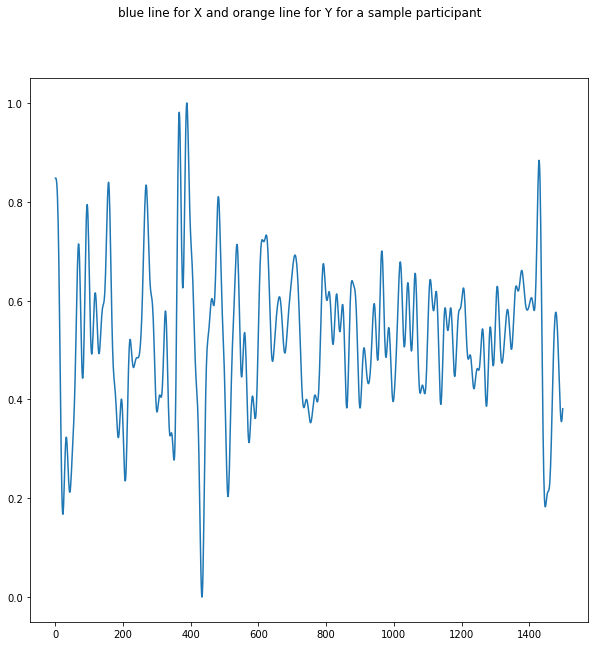

In [ ]:
# plot an example from input
import matplotlib.pyplot as plt

timepoint_for_plot_X = range(0, number_of_timepoint_for_X)
timepoint_for_plot_Y = range(number_of_timepoint_for_X, number_of_timepoint_for_X + number_of_timepoint_for_Y)

fig, ax = plt.subplots(number_of_signal_channel_in_use, 1)
fig.suptitle('blue line for X and orange line for Y for a sample participant')
fig.set_size_inches(10, 10)

for channel_counter in range(number_of_signal_channel_in_use):
  if number_of_signal_channel_in_use>1:
    ax[channel_counter].plot(timepoint_for_plot_X, np_X[0 , : , channel_counter])
    ax[channel_counter].plot(timepoint_for_plot_Y, np_Y[0 , : , channel_counter])
  else:
    ax.plot(timepoint_for_plot_X, np_X[0 , : , channel_counter])
   # ax.plot(timepoint_for_plot_Y, np_Y[0 , : , channel_counter])

plt.show()

In [ ]:
# reshape Y from 2-D to 1-D

np_Y_flat = np_Y.reshape(number_of_total_separable_X ,number_of_timepoint_for_Y*number_of_signal_channel_in_use)

print(np_Y_flat.shape)

(162, 1)


In [ ]:
# split X & Y to train & test

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np_X, np_Y_flat, test_size=x_test_to_total_x_ratio)
x_test_no_touch = x_test

print(len(X))
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

print(len(Y))
print(len(y_train[0]))
print(len(y_test[0]))

162
145
17
145
17
162
1
1


In [ ]:
# make model
hidden_units = 27

from numpy.random import seed
seed(2)
import tensorflow
tensorflow.random.set_seed(2)

cells = [IndRNNCell(hidden_units),
         IndRNNCell(hidden_units)]
# !pip install keras
# !pip install tensorflow
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import LSTM
import tensorflow as tf

from keras.layers import TimeDistributed
from keras.layers import AveragePooling1D
from keras.layers import Flatten


model = Sequential()
model.add(RNN(cells, return_sequences=True, input_shape = (number_of_timepoint_for_X , number_of_signal_channel_in_use)))
# model.add(Dense(num_classes, activation='softmax'))


# model = Sequential()
# model.add(LSTM(150, input_shape = (number_of_timepoint_for_X , number_of_signal_channel_in_use)))
model.add(TimeDistributed(Dense(1)))
# model.add(Dropout(0.1))
# model.add(AveragePooling1D(50))
model.add(Flatten())
# model.add(Dropout(0.1))
# model.add(Dense(1))
model.add(Dense(number_of_signal_channel_in_use*number_of_timepoint_for_Y))

model.summary()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:142: UserWarning: IndRNNCell: Number of timesteps could not be determined. 
Defaulting to max clipping range of 1.0. 
If this model was trained using a specific timestep during training, inference may be wrong due to this default setting.
Please ensure that you use the same number of timesteps during training and evaluation


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 1500, 27)          864       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1500, 1)           28        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1501      
Total params: 2,393
Trainable params: 2,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200) 
checkpoint_name = 'best_model for hidden units =' + str(hidden_units) + 'and trial = [1], and x_Timepoints=' +str(number_of_timepoint_for_X) +'and Y_Timepoints =' + str(periods_of_Y_timepoint_for_predict)+ ' .hdf5'
MC = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [ES, MC]
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,save_best_only=True, save_weights_only=True, verbose=1)

Train on 145 samples, validate on 17 samples
Epoch 1/50
145/145 [==============================] - 5s 32ms/step - loss: 0.7419 - accuracy: 0.0069 - val_loss: 0.4575 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.45753, saving model to best_model for hidden units =27and trial = [1], and x_Timepoints=1500and Y_Timepoints =500 .hdf5
Epoch 2/50
145/145 [==============================] - 3s 19ms/step - loss: 0.6137 - accuracy: 0.0069 - val_loss: 0.4750 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.45753
Epoch 3/50
145/145 [==============================] - 3s 19ms/step - loss: 0.4132 - accuracy: 0.0069 - val_loss: 0.2515 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 0.45753 to 0.25145, saving model to best_model for hidden units =27and trial = [1], and x_Timepoints=1500and Y_Timepoints =500 .hdf5
Epoch 4/50
145/145 [==============================] - 3s 19ms/step - loss: 0.2373 - accuracy: 0.0069 - val_loss: 0.1990 - val_

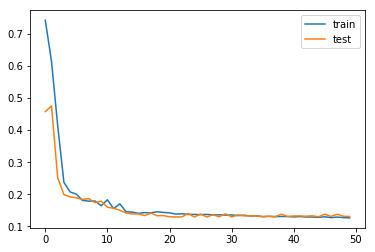

In [ ]:
# train model

history = model.fit(x_train, y_train, epochs= 50, batch_size=50 ,validation_data= (x_test, y_test), verbose=1, shuffle=False, callbacks= callbacks_list)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# input_X_for_test = test_participant_trial[: , 0:number_of_timepoint_for_X , :]
# normalized_reformed_data_for_a_batch
input_X_for_test = normalized_reformed_data_for_a_batch[: , 0:number_of_timepoint_for_X , :]
# for_store_predicted_X = test_participant_trial[: , 0:number_of_timepoint_for_X , :]
for_store_predicted_X = normalized_reformed_data_for_a_batch[: , 0:number_of_timepoint_for_X , :]

end_point_for_prediction = number_of_timepoint_for_X + periods_of_Y_timepoint_for_predict*number_of_timepoint_for_Y
original_X_for_plot = test_participant_trial[: , 0:end_point_for_prediction , :]
for time_period_counter in range(periods_of_Y_timepoint_for_predict):
  y_pred=model.predict(input_X_for_test)
  reshaped_y_pred = y_pred.reshape(len(input_X_for_test) , number_of_timepoint_for_Y , number_of_signal_channel_in_use)
  for_store_predicted_X =np.concatenate((for_store_predicted_X, reshaped_y_pred), axis=1)
  temp_input_X_for_test = np.concatenate((input_X_for_test, reshaped_y_pred), axis=1)
  # print(temp_input_X_for_test.shape)
  # print(for_store_predicted_X.shape)
  input_X_for_test = np.delete(temp_input_X_for_test, np.s_[0:number_of_timepoint_for_Y:], 1)

for_store_predicted_X = np.delete(for_store_predicted_X, np.s_[0:number_of_timepoint_for_X:], 1)


0.01787095
0.054077362008750796


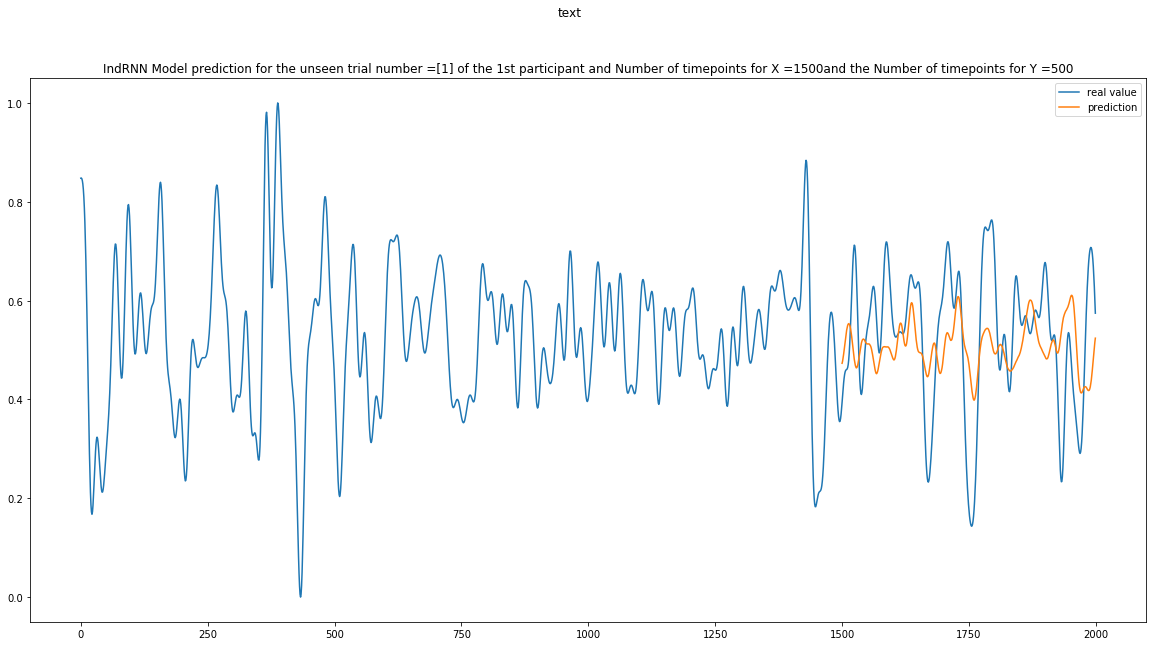

In [ ]:
 # plot predicted vs original
from sklearn.metrics import r2_score

timepoint_for_plot_original_X = range(0, end_point_for_prediction)
# timepoint_for_plot_first_input_X = range(0, number_of_timepoint_for_X)
timepoint_for_plot_predicted_X = range(number_of_timepoint_for_X, end_point_for_prediction)
RMSE = mean_squared_error(normalized_reformed_data_for_a_batch[0 , number_of_timepoint_for_X: , channel_counter], for_store_predicted_X[0 , : , channel_counter])
RMSE1 = "{:.8f}".format(RMSE)
print(RMSE1)
R2 = r2_score(normalized_reformed_data_for_a_batch[0 , number_of_timepoint_for_X: , channel_counter], for_store_predicted_X[0 , : , channel_counter])
print(R2)
#Rsquared=1-(RMSE1/mean_squared_error(original_X_for_plot[0 , 1700: , channel_counter],mean(original_X_for_plot[0 , 1700: , channel_counter])))
#print(Rsquared)
fig, axis = plt.subplots(number_of_signal_channel_in_use, 1)
fig.suptitle('text')
fig.set_size_inches(20, 10)

for channel_counter in range(number_of_signal_channel_in_use):
  if number_of_signal_channel_in_use>1:
    axis[channel_counter].plot(timepoint_for_plot_original_X[:2000], original_X_for_plot[0 , : , channel_counter] ,label = 'real value')
    axis[channel_counter].plot(timepoint_for_plot_predicted_X, for_store_predicted_X[0 , : , channel_counter] ,label= 'prediction')
  else:
    axis.plot(timepoint_for_plot_original_X[:2000], normalized_reformed_data_for_a_batch[0 , : , channel_counter] , label = 'real value')
    axis.plot(timepoint_for_plot_predicted_X, for_store_predicted_X[0 , : , channel_counter] , label= 'prediction')
  
plt.title('IndRNN Model prediction for the unseen trial number =' + str(trial_index_for_test_in_each_participant)+ ' of the 1st participant and Number of timepoints for X =' +str(number_of_timepoint_for_X) + 'and the Number of timepoints for Y =' + str(periods_of_Y_timepoint_for_predict) )
plt.legend()
plt.show()

In [ ]:
                      # #### plot predicted vs original FOR CHANNEL 11###
# from sklearn.metrics import r2_score

# timepoint_for_plot_original_X = range(0, end_point_for_prediction)
# # timepoint_for_plot_first_input_X = range(0, number_of_timepoint_for_X)
# timepoint_for_plot_predicted_X = range(number_of_timepoint_for_X, end_point_for_prediction)
# RMSE = mean_squared_error(original_X_for_plot[0 , number_of_timepoint_for_X: , 11], for_store_predicted_X[0 , : , 11])
# RMSE1 = "{:.8f}".format(RMSE)
# print(RMSE1)
# R2 = r2_score(original_X_for_plot[0 , number_of_timepoint_for_X: , 11], for_store_predicted_X[0 , : , 11])
# print(R2)
# #Rsquared=1-(RMSE1/mean_squared_error(original_X_for_plot[0 , 1700: , channel_counter],mean(original_X_for_plot[0 , 1700: , channel_counter])))
# #print(Rsquared)
# fig, axis = plt.subplots(number_of_signal_channel_in_use, 1)
# fig.suptitle('text')
# fig.set_size_inches(20, 10)


# # for channel_counter in range(number_of_signal_channel_in_use):
# #   if number_of_signal_channel_in_use>1:
# #     axis[channel_counter].plot(timepoint_for_plot_original_X[:2000], original_X_for_plot[0 , : , 11] ,label = 'real value')
# #     axis[channel_counter].plot(timepoint_for_plot_predicted_X, for_store_predicted_X[0 , : , 11] ,label= 'prediction')
# #   else:
# #     axis.plot(timepoint_for_plot_original_X[:2000], original_X_for_plot[0 , : , 11] , label = 'real value')
# #     axis.plot(timepoint_for_plot_predicted_X, for_store_predicted_X[0 , : , 11] , label= 'prediction')
  
# axis.plot(timepoint_for_plot_original_X[:2000], original_X_for_plot[0 , : , 11] , label = 'real value')
# axis.plot(timepoint_for_plot_predicted_X, for_store_predicted_X[0 , : , 11] , label= 'prediction')
  

# plt.title('IndRNN Model prediction for the unseen trial number =' + str(trial_index_for_test_in_each_participant)+'of the 1st participant' )
# plt.legend()
# plt.show()

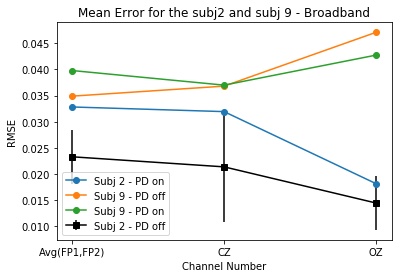

In [ ]:
import matplotlib.pyplot as plt

Alpha=[]
X_Label=[]
fig, axis = plt.subplots(1, 1)
Alpha=[0.00121,0.0018,0.00122,0.00184,0.00188,0.00180,0.0023]
#yerror=[0.00375,0.0024,0.0289,0.006,0.01513,0.0117,0.0073,0.0077,0.0273,0.0138]
X_Label=['Avg(FP1,FP2)' , 'CZ' , 'OZ']

Alpha_1=[0.0232809,0.0213512,0.0144145]
Alpha_2=[0.03282,0.03193,0.01811]
Alpha_3=[0.03489,0.03681,0.04713]
Alpha_4=[0.03980,0.03700,0.04276]

yerror_1=[0.005202,0.0106,0.00514]


plt.errorbar(X_Label,Alpha_1,yerror_1, fmt='k',marker='s',capthick=3,label='Subj 2 - PD off')
# axis.plot(X_Label,Alpha_1,label='Subj 2 - PD off', marker = 'o')
axis.plot(X_Label,Alpha_2,label='Subj 2 - PD on', marker = 'o')
axis.plot(X_Label,Alpha_3, label='Subj 9 - PD off', marker = 'o')
axis.plot(X_Label,Alpha_4, label='Subj 9 - PD on', marker = 'o' )

plt.title('Mean Error for the subj2 and subj 9 - Broadband')
plt.xlabel('Channel Number')
plt.ylabel('RMSE')
plt.show
plt.legend()

In [ ]:
# import matplotlib.pyplot as plt

# Alpha=[]
# X_Label=[]
# fig, axis = plt.subplots(1, 1)
# Alpha=[0.00121,0.0018,0.00122,0.00184,0.00188,0.00180,0.0023]
# #yerror=[0.00375,0.0024,0.0289,0.006,0.01513,0.0117,0.0073,0.0077,0.0273,0.0138]
# X_Label=['Avg(FP1,FP2)' , 'CZ' , 'OZ']

# Alpha_1=[0.02170,0.02556,0.01248]
# Alpha_2=[0.03282,0.03193,0.01811]
# Alpha_3=[0.03489,0.03681,0.04713]
# Alpha_4=[0.03980,0.03700,0.04276]




# axis.plot(X_Label,Alpha_1,label='Subj 2 - PD off', marker = 'o')
# axis.plot(X_Label,Alpha_2,label='Subj 2 - PD on', marker = 'o')
# axis.plot(X_Label,Alpha_3, label='Subj 9 - PD off', marker = 'o')
# axis.plot(X_Label,Alpha_4, label='Subj 9 - PD on', marker = 'o' )

# plt.title('Mean Error for the subj2 and subj 9 - Broadband')
# plt.xlabel('Channel Number')
# plt.ylabel('RMSE')
# plt.show
# plt.legend()

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[0.021820853, 0.02137491, 0.01712867, 0.029870523, 0.02759315, 0.03462383, 0.03749387, 0.03320375, 0.032445473, 0.02966305]
<type 'list'>
<type 'list'>


<function matplotlib.pyplot.show>

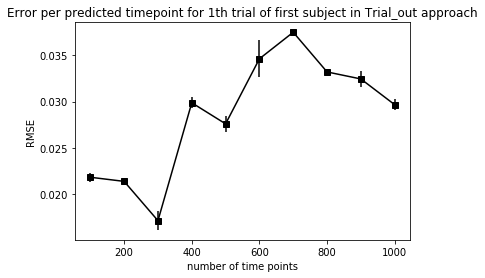

In [ ]:
Alpha=[0.021820853,0.02137491,0.01712867,0.029870523,0.02759315,0.03462383,0.03749387,0.03320375,0.032445473,0.02966305]
X_Label=[100,200,300,400,500,600,700,800,900,1000]
yerror=[0.0005,0.0002,0.001,0.0006,0.0009,0.002,0,0.0002,0.0009,0.0006]
print(X_Label)
print(Alpha)
print(type(Alpha))
print(type(X_Label))
plt.errorbar(X_Label,Alpha,yerror, fmt='k',marker='s',capthick=3)
plt.title('Error per predicted timepoint for 1th trial of first subject in Trial_out approach')
plt.xlabel('number of time points')
plt.ylabel('RMSE')
plt.show

In [ ]:
# Alpha=[]
# X_Label=[]
# # Alpha.pop()
# X_Label.append(periods_of_Y_timepoint_for_predict)
# #ac=tf.divide(RMSE,periods_of_Y_timepoint_for_predict)
# #ac1 = "{:.8f}".format(ac)
# Alpha.append(RMSE)
# #X_Label.pop (18)
# print(X_Label)
# # print(Error)
# alpha_n=np.array(Alpha)
# Aalpha=list(map(float,Alpha))
# print(Aalpha)
# print(type(alpha_n))
# print(type(Alpha))
# print(type(X_Label))
# print(alpha_n.shape)
# print(type(Aalpha))

In [ ]:
# # plt.plot(X_Label,Aalpha,marker='*', linestyle='-')
# plt.errorbar(X_Label,Aalpha,marker='s', capthick=3)
# plt.title('Error per predicted timepoint for 1th trial of first subject in Trial_out approach')
# plt.xlabel('number of time points')
# plt.ylabel('RMSE')
# plt.show